<a href="https://colab.research.google.com/github/NazarKarpiuk/kerasFaceAndAge/blob/main/kerasFaceAndAge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"comlvkaggle","key":"5c82969c398f3816297282a027d31257"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list #all available datasets
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv #exact dataset 

 98% 62.0M/63.2M [00:00<00:00, 69.2MB/s]
100% 63.2M/63.2M [00:00<00:00, 76.7MB/s]


In [ ]:
!unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


# Import

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as plgo
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from sklearn.model_selection import train_test_split
import plotly.express as px

In [ ]:
data = pd.read_csv('/content/age_gender.csv')

In [ ]:
data['pixels']

0        129 128 128 126 127 130 133 135 139 142 145 14...
1        164 74 111 168 169 171 175 182 184 188 193 199...
2        67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3        193 197 198 200 199 200 202 203 204 205 208 21...
4        202 205 209 210 209 209 210 211 212 214 218 21...
                               ...                        
23700    127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701    23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702    59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703    45 108 120 156 206 197 140 180 191 199 204 207...
23704    156 161 160 165 170 173 166 177 183 191 187 18...
Name: pixels, Length: 23705, dtype: object

In [ ]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [ ]:
data['pixels']

0        [129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...
1        [164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....
2        [67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79....
3        [193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202...
4        [202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210...
                               ...                        
23700    [127.0, 100.0, 94.0, 81.0, 77.0, 77.0, 74.0, 9...
23701    [23.0, 28.0, 32.0, 35.0, 42.0, 47.0, 68.0, 85....
23702    [59.0, 50.0, 37.0, 40.0, 34.0, 19.0, 30.0, 101...
23703    [45.0, 108.0, 120.0, 156.0, 206.0, 197.0, 140....
23704    [156.0, 161.0, 160.0, 165.0, 170.0, 173.0, 166...
Name: pixels, Length: 23705, dtype: object

In [ ]:
print(f"Rows:", len(data['pixels']))

Rows: 23705


In [ ]:
## pixel data normalization
data['pixels'] = data['pixels'].apply(lambda x: x/255)

In [ ]:
data.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [ ]:
data_age_dist = data['age'].value_counts()
data_ethnicity_dist = data['ethnicity'].value_counts()
data_gender_dist = data['gender'].value_counts().rename(index={0:'male',1:'female'})

In [ ]:
def dist_plot(x,y):
  figure = plgo.Figure([plgo.Bar(x=x, y=y)])
  figure.show()

In [ ]:
dist_plot(data_age_dist.index, data_age_dist.values)

In [ ]:
dist_plot(data_ethnicity_dist.index, data_ethnicity_dist.values)

In [ ]:
dist_plot(data_gender_dist.index, data_gender_dist.values)

In [ ]:
data['pixels']

0        [0.5058824, 0.5019608, 0.5019608, 0.49411765, ...
1        [0.6431373, 0.2901961, 0.43529412, 0.65882355,...
2        [0.2627451, 0.27450982, 0.2784314, 0.27450982,...
3        [0.75686276, 0.77254903, 0.7764706, 0.78431374...
4        [0.7921569, 0.8039216, 0.81960785, 0.8235294, ...
                               ...                        
23700    [0.49803922, 0.39215687, 0.36862746, 0.3176470...
23701    [0.09019608, 0.10980392, 0.1254902, 0.13725491...
23702    [0.23137255, 0.19607843, 0.14509805, 0.1568627...
23703    [0.1764706, 0.42352942, 0.47058824, 0.6117647,...
23704    [0.6117647, 0.6313726, 0.627451, 0.64705884, 0...
Name: pixels, Length: 23705, dtype: object

In [ ]:
pixel_data = np.array(data['pixels'].tolist())

In [ ]:
pixel_data = pixel_data.reshape(pixel_data.shape[0],48,48,1)

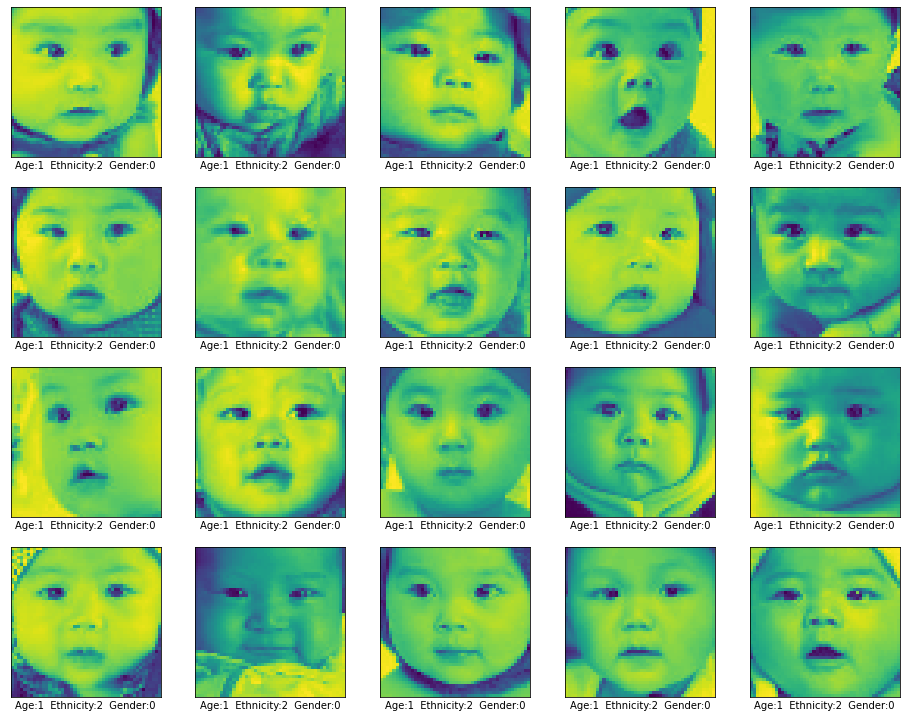

In [ ]:
plt.figure(figsize=(16,16))
for i in range(100,120):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

Model train

In [ ]:
x = pixel_data
y = data['gender']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=37)

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2000):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

#model.summary()

In [ ]:
history = model.fit(
    x_train, y_train, epochs=30, validation_split=0.2, batch_size=64, callbacks=[callback]
)

Epoch 1/30
208/208 [==============================] - 35s 11ms/step - loss: 0.6566 - accuracy: 0.6600 - val_loss: 0.5756 - val_accuracy: 0.8295
Epoch 2/30
208/208 [==============================] - 2s 8ms/step - loss: 0.3958 - accuracy: 0.8234 - val_loss: 0.4264 - val_accuracy: 0.8545
Epoch 3/30
208/208 [==============================] - 2s 8ms/step - loss: 0.3437 - accuracy: 0.8465 - val_loss: 0.3225 - val_accuracy: 0.8557
Epoch 4/30
208/208 [==============================] - 2s 8ms/step - loss: 0.3167 - accuracy: 0.8584 - val_loss: 0.3101 - val_accuracy: 0.8623
Epoch 5/30
208/208 [==============================] - 2s 8ms/step - loss: 0.2974 - accuracy: 0.8705 - val_loss: 0.2751 - val_accuracy: 0.8726
Epoch 6/30
208/208 [==============================] - 2s 8ms/step - loss: 0.2745 - accuracy: 0.8796 - val_loss: 0.2729 - val_accuracy: 0.8750
Epoch 7/30
208/208 [==============================] - 2s 8ms/step - loss: 0.2546 - accuracy: 0.8877 - val_loss: 0.2702 - val_accuracy: 0.8882
Epoc

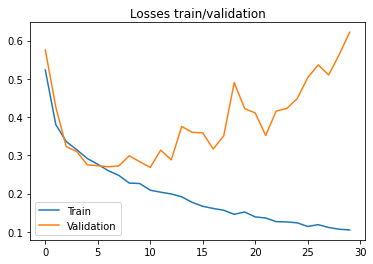

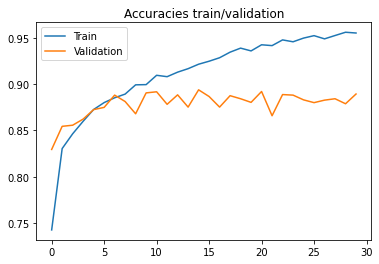

In [ ]:
plt.title("Losses train/validation")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()

plt.title("Accuracies train/validation")
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(x_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.5868685841560364
Test Accuracy: 0.8848425149917603
